This is a sandbox, an almost blank canvas meant to let you fiddle with geodata from any source. The given example should do the following : 
   - We want to find a building, in Geneva, Lausanne or Bern, with less than 48db of noise during night time.
   - The building should be within 200 meters from either a lake or a river
   https://api3.geo.admin.ch/rest/services/api/MapServer/find?layer=ch.bfs.gebaeude_wohnungs_register&searchText=Lausanne&searchField=gdename&returnGeometry=true


In [1]:
import os
import requests
import pandas
import json
import geopandas
import zipfile
import io
import gdal
import fiona
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.geometry import Point

https://data.geo.admin.ch/ch.bfe.ladestellen-elektromobilitaet/data/ch.bfe.ladestellen-elektromobilitaet_fr.json 200
https://data.geo.admin.ch/ch.bfe.ladestellen-elektromobilitaet/data/oicp/ch.bfe.ladestellen-elektromobilitaet.json 200
https://data.geo.admin.ch/ch.bfe.ladestellen-elektromobilitaet/status/oicp/ch.bfe.ladestellen-elektromobilitaet.json 200


/usr/local/lib/python3.8/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.8/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


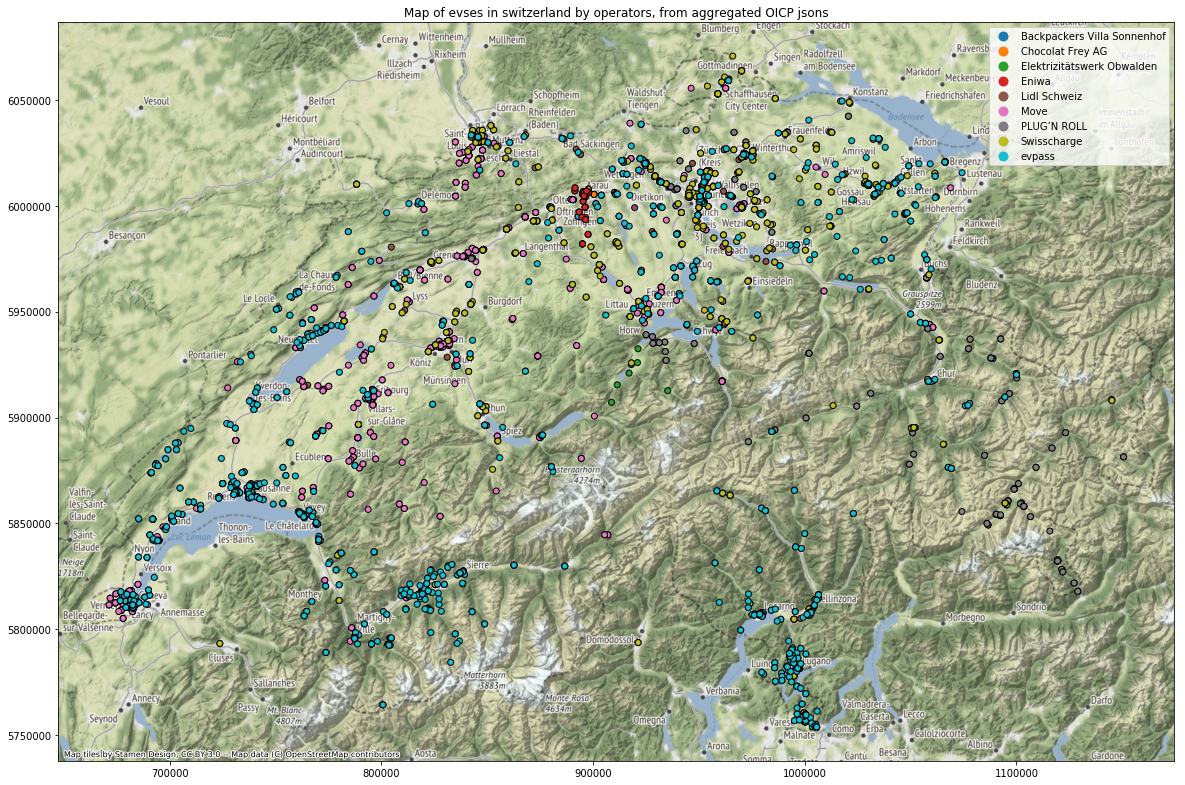

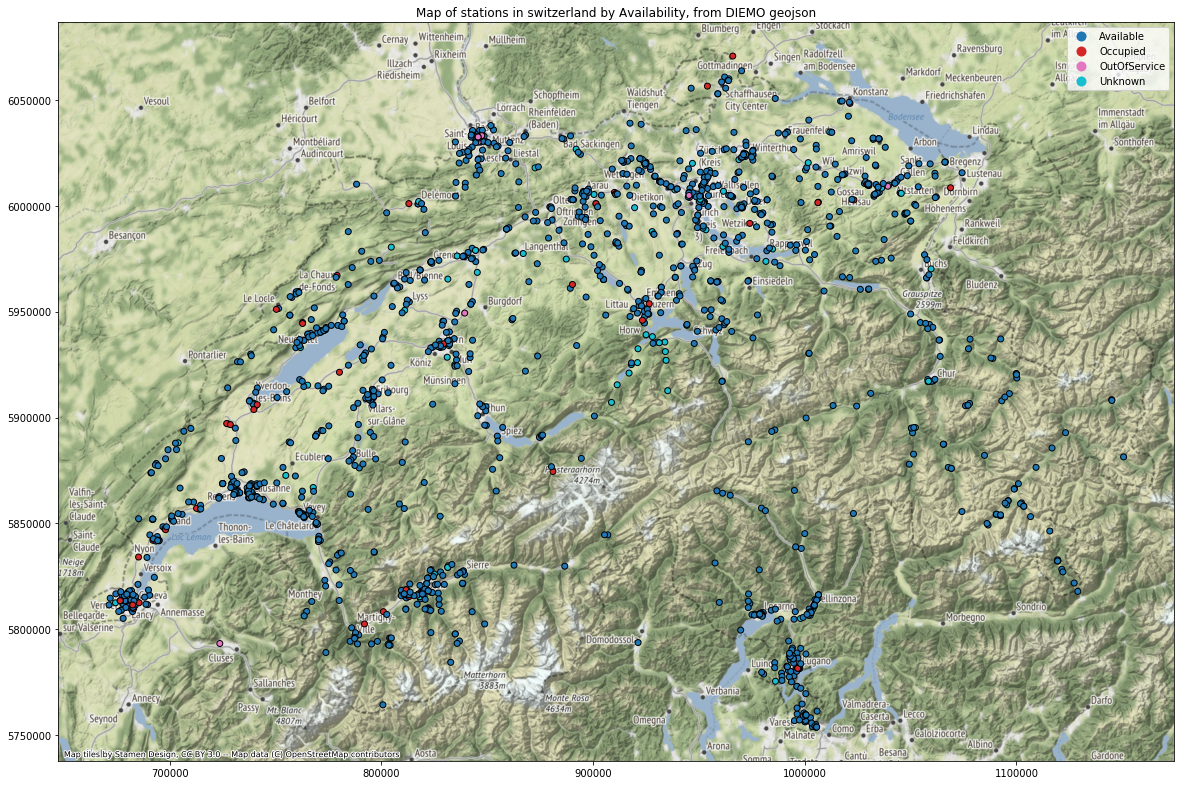

In [2]:
diemo_url = 'https://data.geo.admin.ch/ch.bfe.ladestellen-elektromobilitaet/data/ch.bfe.ladestellen-elektromobilitaet_fr.json'
diemo_full_oicp_data_url = 'https://data.geo.admin.ch/ch.bfe.ladestellen-elektromobilitaet/data/oicp/ch.bfe.ladestellen-elektromobilitaet.json'
diemo_full_oicp_status_url = 'https://data.geo.admin.ch/ch.bfe.ladestellen-elektromobilitaet/status/oicp/ch.bfe.ladestellen-elektromobilitaet.json'

r_geojson = requests.get(diemo_url)
r_data = requests.get(diemo_full_oicp_data_url)
r_status = requests.get(diemo_full_oicp_status_url)


print(r_geojson.url, r_geojson.status_code)
print(r_data.url, r_data.status_code)
print(r_status.url, r_status.status_code)
gdf = geopandas.read_file(diemo_url)
dataframe = pandas.DataFrame()
for i in range(len(r_data.json()['EVSEData'])):
    operator_id = r_data.json()['EVSEData'][i]['OperatorID']
    operator_name = r_data.json()['EVSEData'][i]['OperatorName']
    df_1 = pandas.DataFrame(r_data.json()['EVSEData'][i]['EVSEDataRecord'])
    df_2 = pandas.DataFrame(r_status.json()['EVSEStatuses'][i]['EVSEStatusRecord'])
    
    if df_1.size > 0:
        merged = df_1.merge(df_2, left_on='ChargingStationId', right_on='EvseID', left_index=True, copy=False)
        merged['OperatorID'] = [operator_id for l in range(len(r_data.json()['EVSEData'][i]['EVSEDataRecord']))]
        merged['OperatorName'] = [operator_name for l in range(len(r_data.json()['EVSEData'][i]['EVSEDataRecord']))]
        merged['latitude'] = [float(line['Google'].split(',')[1]) for line in df_1['GeoCoordinates']]
        merged['longitude'] = [float(line['Google'].split(',')[0]) for line in df_1['GeoCoordinates']]        
        if dataframe.size == 0:
            dataframe = merged
        else:
            dataframe = dataframe.append(merged)

# data_df = pandas.DataFrame.from_dict((r_data.json()))
# pd = pandas.read_csv(z.read('CH.csv'))
# print(diemo_data_dataframe)
# print(diemo_status_dataframe)

gdf_diemo_full = geopandas.GeoDataFrame(dataframe, geometry=geopandas.points_from_xy(dataframe.longitude, dataframe.latitude))
gdf_diemo_full.crs={'init': 'epsg:4326'}
gdf.crs={'init': 'epsg:4326'}
mp = gdf_diemo_full.cx[0:,10:].to_crs(epsg=3857).plot(column="OperatorName", figsize=(20,20), legend=True , edgecolor='black')
mp.set_title('Map of evses in switzerland by operators, from aggregated OICP jsons')
ctx.add_basemap(mp)
mp2 = gdf.cx[0:,10:].to_crs(epsg=3857).plot(column="Availability", figsize=(20,20), edgecolor='black', legend=True)
mp2.set_title('Map of stations in switzerland by Availability, from DIEMO geojson')
ctx.add_basemap(mp2)

In [3]:
print(gdf_diemo_full)

                                              Address IsOpen24Hours  \
0   {'City': 'Interlaken', 'Country': 'CHE', 'Hous...         False   
0   {'City': 'Interlaken', 'Country': 'CHE', 'Hous...         False   
0   {'City': 'Interlaken', 'Country': 'CHE', 'Hous...         False   
0   {'City': 'Sarnen', 'Country': 'CHE', 'HouseNum...         False   
1   {'City': 'Sachseln', 'Country': 'CHE', 'HouseN...         False   
..                                                ...           ...   
49  {'City': 'Aarau', 'Country': 'CH', 'HouseNum':...          True   
53  {'City': 'Aarau', 'Country': 'CH', 'HouseNum':...          True   
53  {'City': 'Aarau', 'Country': 'CH', 'HouseNum':...          True   
54  {'City': 'Schöftland', 'Country': 'CH', 'House...          True   
54  {'City': 'Schöftland', 'Country': 'CH', 'House...          True   

   ChargingStationId                    GeoCoordinates lastUpdate  \
0   CH*BVS*E001*0001    {'Google': '7.86187,46.68459'}       None   
0   CH*BV